In [ ]:
!pip install emoji
!pip install contractions
!pip install inflect
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.5 MB/s eta 0:00:00


In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from typing import Callable, Iterable


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
import emoji
import unicodedata
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
#загружаем датасет
path = kagglehub.dataset_download("amandam1/friends-scripts")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/amandam1/friends-scripts/versions/1


In [ ]:
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(path, filename)
        break

In [ ]:
df = pd.read_csv(csv_file_path)

In [ ]:
#оставляем только нужные столбцы
text = df[['character','line']]

In [ ]:
#удаление пропущенных значений и дубликатов
text = text.dropna()

In [ ]:
text = text.drop_duplicates()

In [ ]:
text.reset_index(drop=True, inplace=True)

In [ ]:
text

,character,line
0,monica,there's nothing to tell! he's just some guy i...
1,joey,"c'mon, you're going out with the guy! there's..."
2,chandler,"all right joey, be nice. so does he have a h..."
3,phoebe,"wait, does he eat chalk?"
4,phoebe,"just, 'cause, i don't want her to go through ..."
...,...,...
56399,chandler,"oh, it's gonna be okay."
56400,rachel,(crying) do you guys have to go to the new ho...
56401,monica,we got some time.
56402,rachel,"okay, should we get some coffee?"


In [ ]:
# Создаем группы, которые увеличиваются, если character меняется
text['group'] = (text['character'] != text['character'].shift()).cumsum()

# Группируем по character и group, объединяя строки line
text = text.groupby(['group', 'character'], as_index=False)['line'].apply(' '.join)

# Удаляем лишний столбец group
text = text.drop(columns=['group'])

In [ ]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53174 entries, 0 to 53173
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   character  53174 non-null  object
 1   line       53174 non-null  object
dtypes: object(2)
memory usage: 831.0+ KB


In [ ]:
text.head(20)

,character,line
0,monica,there's nothing to tell! he's just some guy i...
1,joey,"c'mon, you're going out with the guy! there's..."
2,chandler,"all right joey, be nice. so does he have a h..."
3,phoebe,"wait, does he eat chalk? just, 'cause, i don..."
4,monica,"okay, everybody relax. this is not even a dat..."
5,chandler,"sounds like a date to me. alright, so i'm ba..."
6,all,"oh, yeah. had that dream."
7,chandler,"then i look down, and i realize there's a pho..."
8,joey,instead of...?
9,chandler,that's right.


In [ ]:
print(len(text[text.character == 'chandler']))

7258


In [ ]:
#создаем словарь, где ключ: реплика героя, значение: реплика до реплики героя
questions = {}
for i, c in text.character.items():
  for idx, l in text.line.items():
      if c == 'chandler' and i!=0:
        before = i - 1
        questions[text.line[before]] = text.line[i]

In [ ]:
#создаем датафрейм
data = pd.DataFrame.from_dict(questions,orient = 'index')

In [ ]:
data = data.reset_index(names='phrase before')
data = data.rename(columns = {0:"chandler's phrase"})


In [ ]:
data.to_csv('/content/drive/MyDrive/Задачи генерации в NLP/data.csv')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Задачи генерации в NLP/data.csv')

In [ ]:
#посмотрим словарь стоп-слов
stop_words = set(stopwords.words('english'))
print(stop_words)

{'very', 'by', 'o', "weren't", 'did', 'been', 'against', 'through', 'whom', 'didn', "they'd", 'should', 'will', 'during', "couldn't", 'he', 'she', "we're", "i'd", 'i', 'other', 'of', "you're", "should've", "he's", "it'll", 'from', "that'll", 'theirs', 'at', 'am', 'most', 'a', 'but', 'with', "i'll", 'hers', 'an', 'y', 'again', 'into', "we've", 'off', 'not', 'won', 'after', "she'd", 'where', "i've", 'both', 'on', 'how', "they'll", 'in', 'be', 've', 'if', 'your', 'ourselves', 'being', "wasn't", "they've", 'you', 'own', 'or', 'himself', 'than', 'nor', 'and', 'yourselves', 'me', 'are', 'have', 'more', "isn't", 'her', 'themselves', 'him', 'over', "didn't", 'while', "she'll", 'the', 'do', 'for', "they're", 't', 'mustn', 'further', 'can', 'does', 'hadn', 'haven', 'our', 'above', "she's", 'only', 'wasn', "we'll", "you'd", 'hasn', 'just', 'until', 'herself', 'mightn', 'shouldn', 'll', 'down', 'that', 'these', "wouldn't", 'aren', 'as', "shouldn't", "i'm", "hadn't", 'yourself', "mightn't", 'doesn'

In [ ]:
# Функция для очистки текста
def clean_text(input_text):

    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>', '', input_text)

    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    # Эмоджи и эмотиконы: используем собственную функцию для преобразования эмоджи в текст
    # Важно понимать эмоциональную окраску обрабатываемого текста
    clean_text = emojis_words(clean_text)

    # Приводим все входные данные к нижнему регистру
    clean_text = clean_text.lower()

    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    # Преобразование символов с диакритическими знаками к ASCII-символам: используем функцию normalize из модуля unicodedata и преобразуем символы с диакритическими знаками к ASCII-символам
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Разворачиваем сокращения: текст часто содержит конструкции вроде "don't" или "won't", поэтому развернём подобные сокращения
    clean_text = contractions.fix(clean_text)

    # Убираем специальные символы: избавляемся от всего, что не является "словами"
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

    # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
    stop_words = set(stopwords.words('english'))
    #tokens = word_tokenize(clean_text)
    #tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(word for word in input_text.split() if word not in stop_words)

    # Знаки препинания: далее - удаляем из текста все знаки препинания
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    # И наконец - возвращаем очищенный текст
    return clean_text

# Функция для преобразования эмоджи в слова
def emojis_words(text):

    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "))

    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")

    return clean_text

In [ ]:
#применим функцию clean_data для phrase before
data['clean phrase before'] = data['phrase before'].apply(clean_text)

In [ ]:
data

,phrase before,chandler's phrase,clean phrase before,clean chandler's phrase
0,"c'mon, you're going out with the guy! there's...","all right joey, be nice. so does he have a h...",cmon going guy theres gotta something wrong him,right joey nice hump hump hairpiece
1,"okay, everybody relax. this is not even a dat...","sounds like a date to me. alright, so i'm ba...",okay everybody relax even date two people goin...,sounds like date me alright back high school s...
2,"oh, yeah. had that dream.","then i look down, and i realize there's a pho...",oh yeah dream,look down realize theres phone there
3,instead of...?,that's right.,instead of,thats right
4,no.,all right. very good.,no,right good
...,...,...,...,...
7168,"yeah, yeah, he talked to her, but she got on ...",where's ross?,yeah yeah talked her got plane anyway,wheres ross
7169,has it always been purple?,"(to his children) look around, you guys. this...",always purple,to children look around guys first home happy ...
7170,"oh, honey, i forgot. i promised treeger that ...","oh, okay.",oh honey forgot promised treeger leave keys,oh okay
7171,(crying) this is harder than i thought it wou...,"oh, it's gonna be okay.",crying harder thought would be,oh gonna okay


In [ ]:
import numpy as np

count    7173.000000
mean       45.518333
std        44.318469
min         1.000000
25%        17.000000
50%        33.000000
75%        59.000000
max       861.000000
Name: clean phrase before, dtype: float64


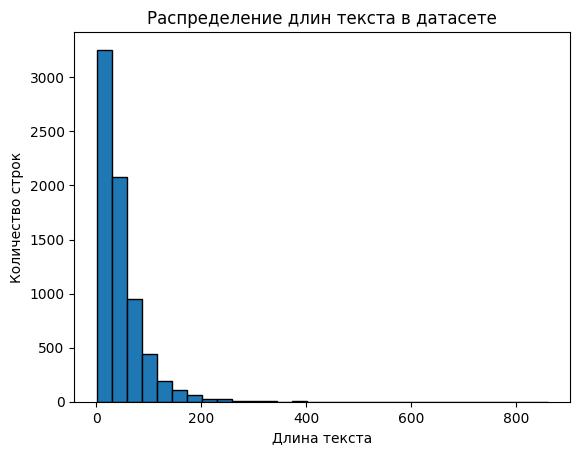

In [ ]:
# посмотрим графики распредления длин текста в датасете. Для "clean phrase before"
text_length = data["clean phrase before"].apply(len)

# Выводим статистику по длине текста
print(text_length.describe())

# Гистограмма распределения длин текста
plt.hist(text_length, bins=30, edgecolor="black")
plt.xlabel("Длина текста")
plt.ylabel("Количество строк")
plt.title("Распределение длин текста в датасете")
plt.show()

count    7173.000000
mean       69.571309
std        66.478115
min         4.000000
25%        28.000000
50%        51.000000
75%        88.000000
max       748.000000
Name: chandler's phrase, dtype: float64


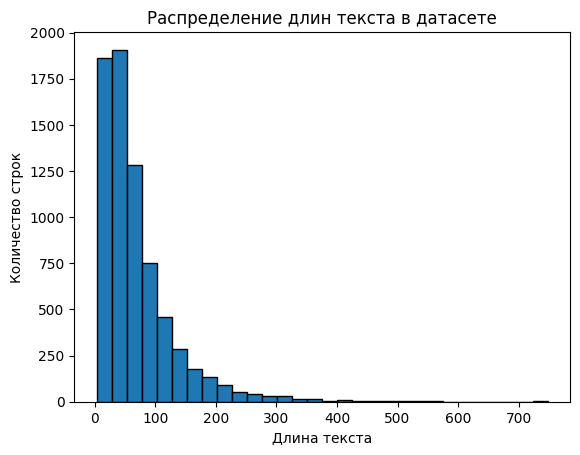

In [ ]:
# посмотрим графики распредления длин текста в датасете. Для "chandler's phrase"
text_length = data["chandler's phrase"].apply(len)

# Выводим статистику по длине текста
print(text_length.describe())

# Гистограмма распределения длин текста
plt.hist(text_length, bins=30, edgecolor="black")
plt.xlabel("Длина текста")
plt.ylabel("Количество строк")
plt.title("Распределение длин текста в датасете")
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
#посмотрим максимальную длину эмбеддинга
model.config.max_position_embeddings

512

In [ ]:
MAX_LENGTH = 512

tokenized_texts = tokenizer([text for text in data],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

In [ ]:
#класс для создания базы векторов
class ModelSearchEngine:
    def __init__(self, model, tokenizer, text_database):
        self.raw_procesed_data = [self.preprocess(sample, tokenizer) for sample in text_database]
        self.base = []
        self.retriever = None
        self.inverted_index = {}
        self._init_retriever(model, tokenizer, text_database)
        self._init_inverted_index(text_database)

    @staticmethod
    def preprocess(sentence: str, tokenizer):
      sentence = clean_text(sentence)
      return tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    '''Этот приватный метод создаёт векторное представление уже токенизированного текста с
    помощью модели BERT, где входные тензоры автоматически перемещаются на устройство модели,
    модель вычисляет вложения без обновления весов, берёт вектор первого токена (CLS) из
    последнего слоя, нормализует его и возвращает как numpy массив, что позволяет получить
    компактное числовое представление текста, сохраняющее его семантическое значение. '''
    def _embed_cls(self, tokenized_text: dict[torch.Tensor]) -> np.array:
        with torch.no_grad():
            model_output = self.retriever(**{k: v.to(self.retriever.device) for k, v in tokenized_text.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0].cpu().numpy()

    '''Этот приватный метод инициализирует систему поиска документов, где сначала сохраняются переданные модель  и
    токенизатор как атрибуты объекта, а затем создаёт базу векторов представлений всех документов из базы данных, где
    каждый документ последовательно обрабатывается методом `preprocess`, преобразуется в векторное представление с
    помощью метода `_embed_bert_cls`, а прогресс обработки отображается через tqdm, в результате чего все векторы
    сохраняются в массиве `self.base` для последующего использования в поиске похожих документов. '''
    def _init_retriever(self, model, tokenizer, text_database):
        self.retriever = model
        self.tokenizer = tokenizer
        self.base = np.array([self._embed_cls(self.preprocess(text, tokenizer)) for text in tqdm(text_database["phrase before"])])
        vector_dim = self.base.shape[1]  # Размерность эмбеддингов
        annoy_index = AnnoyIndex(vector_dim, 'angular')

    # Заполняем индекс
        for i, vec in enumerate(self.base):
          annoy_index.add_item(i, vec)

        # Строим индекс (n_trees = 10 - можно увеличить для большей точности)
        annoy_index.build(30)
        annoy_index.save("annoy_index.ann")  # Можно сохранить для повторного использования



    def retrieve(self, query: str) -> np.array:
        return self._embed_cls(self.preprocess(query, self.tokenizer))

    '''Этот метод выполняет поиск наиболее релевантных документов в базе данных, где для входного запроса сначала создаёт
    векторное представление с помощью метода `retrieve`, затем вычисляет косинусную схожесть между запросом и всеми документами
    в базе, сортирует документы по убыванию схожести и возвращает индексы top_k наиболее релевантных документов в виде списка,
    что позволяет эффективно находить тексты, наиболее близкие по содержанию к поисковому запросу. '''
    def retrieve_documents(self, query: str, top_k=3) -> list[int]:
        query_vector = self.retrieve(query)
        cosine_similarities = cosine_similarity([query_vector], self.base).flatten()
        relevant_indices = np.argsort(cosine_similarities, axis=0)[::-1][:top_k]
        return relevant_indices.tolist()

    def _init_inverted_index(self, text_database: list[str]):
        self.inverted_index = dict(enumerate(text_database["chandler's phrase"]))
    '''Этот метод получает поисковый запрос и возвращает список индексов наиболее релевантных документов из базы данных, где
    сначала вызывает метод `retrieve_documents` для получения индексов top_k наиболее подходящих документов, а затем использует
    обратный индекс (`inverted_index`) для преобразования этих индексов в их исходные идентификаторы, что позволяет эффективно
    извлекать и возвращать идентификаторы найденных документов в виде списка целых чисел. '''
    def display_relevant_docs(self, query, full_database, top_k=3) -> list[int]:
         docs_indexes = self.retrieve_documents(query, top_k=top_k)
         return [int(self.inverted_index[idx].replace('\xa0', ' ')) for idx in docs_indexes]






simple_search_engine = ModelSearchEngine(model, tokenizer, data)




  0%|          | 0/7173 [00:00<?, ?it/s]

  0%|          | 10/7173 [00:00<01:11, 99.91it/s]

  0%|          | 20/7173 [00:00<01:13, 96.99it/s]

  0%|          | 30/7173 [00:00<01:13, 96.91it/s]

  1%|          | 40/7173 [00:00<01:15, 95.08it/s]

  1%|          | 51/7173 [00:00<01:12, 98.46it/s]

  1%|          | 61/7173 [00:00<01:15, 94.64it/s]

  1%|          | 72/7173 [00:00<01:13, 96.67it/s]

  1%|          | 83/7173 [00:00<01:11, 98.56it/s]

  1%|▏         | 93/7173 [00:00<01:12, 98.08it/s]

  1%|▏         | 103/7173 [00:01<01:14, 94.72it/s]

  2%|▏         | 113/7173 [00:01<01:15, 93.63it/s]

  2%|▏         | 123/7173 [00:01<01:14, 94.47it/s]

  2%|▏         | 133/7173 [00:01<01:13, 95.19it/s]

  2%|▏         | 143/7173 [00:01<01:16, 91.86it/s]

  2%|▏         | 153/7173 [00:01<01:15, 93.00it/s]

  2%|▏         | 163/7173 [00:01<01:15, 92.73it/s]

  2%|▏         | 173/7173 [00:01<01:14, 93.95it/s]

  3%|▎         | 184/7173 [00:01<01:12, 96.42it/s]

  3%|▎         | 195/7173 [00

384


In [ ]:
#проверим как работает модель на интерфейсе
index = AnnoyIndex(384, 'angular')
index.load("annoy_index.ann")

True

In [ ]:
def embed_cls(user_input):
  user_input = clean_text(user_input)
  t = tokenizer(user_input, padding=True, truncation=True, return_tensors='pt')
  with torch.no_grad():
      model_output = model(**{k: v.to(model.device) for k, v in t.items()})
  embeddings = model_output.last_hidden_state[:, 0, :]
  embeddings = torch.nn.functional.normalize(embeddings)
  return embeddings[0].cpu().numpy()
def get_response(user_input,data):
    user_vector = embed_cls(user_input)
    closest_index = index.get_nns_by_vector(user_vector, 1)[0]  # Ищем ближайший вектор
    return data["chandler's phrase"][closest_index].replace('\xa0', ' ')

In [ ]:
get_response('what is news?', data)

' thank you. i got a job in advertising. (everybody cheers)'